In [1]:
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Input, Model
from keras.layers import Dense
from scipy.stats import kendalltau, pearsonr
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.model_selection import cross_validate, KFold

import os

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import math as mt
from pylab import savefig
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import layers

from keras import backend as K

# model evaluation
from sklearn.model_selection import KFold, train_test_split 
from sklearn.metrics import r2_score, mean_squared_error

Using TensorFlow backend.


In [2]:
# LOAD TRAINING DATA FOR TRANSFER LEARNING
df_APEC_total = pd.read_excel('./data/df_APEC_total.xlsx',index_col=0).fillna(0)
data = df_APEC_total
train_dataset = data.sample(frac=0.8,random_state=42)
test_dataset = data.drop(train_dataset.index)

train_stats = train_dataset.describe()
train_stats = train_stats.drop(['Part weight','Length','Angle', 'Height', 'Width'], axis=1)
train_stats = train_stats.transpose()
train_labels = train_dataset[['Part weight']]
test_labels = test_dataset[['Part weight']]

def norm(x):
    return (x - train_stats['mean']) / train_stats['std'] #zero-mean normalization, same with sklearn.preprocessing.StandardScaler
train_dataset = train_dataset.drop(['Part weight','Length','Angle','Height', 'Width'], axis=1)
test_dataset = test_dataset.drop(['Part weight','Length','Angle','Height', 'Width'], axis=1)
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

X_train = normed_train_data.fillna(0)
X_test = normed_test_data.fillna(0)
y_train = train_labels
y_test = test_labels

x = np.array(X_train, dtype=np.float)
y = np.array(y_train, dtype=np.float)
x = x.astype(float)
y = y.astype(float)

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)
mol_num, feat_num = x.shape
print("Number of materials for training = %i, Number of features = %i\n" % (mol_num, feat_num))

Number of materials for training = 801, Number of features = 50



In [3]:
# load the dataset 
df_APEC_total=pd.read_excel('./data/df_APEC_total.xlsx',index_col=0)
df_PLEXIGLAS_total=pd.read_excel('./data/df_PLEXIGLAS_total.xlsx',index_col=0)
df_SABIC_total=pd.read_excel('./data/df_SABIC_total.xlsx',index_col=0)
df_ULTEM_total=pd.read_excel('./data/df_ULTEM_total.xlsx',index_col=0)
df_ULTRAMID_total=pd.read_excel('./data/df_ULTRAMID_total.xlsx',index_col=0)
df_VALOX_total=pd.read_excel('./data/df_VALOX_total.xlsx',index_col=0)
df = pd.concat([df_PLEXIGLAS_total, df_SABIC_total, df_ULTEM_total,
                df_ULTRAMID_total, df_VALOX_total])
data = df.fillna(0)
#data = pd.read_excel('./data/df_VALOX_total.xlsx',index_col=0).fillna(0)

train_dataset = data.sample(frac=0.8,random_state=42)
test_dataset = data.drop(train_dataset.index)

train_stats = train_dataset.describe()
train_stats = train_stats.drop(['Part weight','Length','Angle', 'Height', 'Width'], axis=1)
train_stats = train_stats.transpose()
train_labels = train_dataset[['Part weight']]
test_labels = test_dataset[['Part weight']]

def norm(x):
    return (x - train_stats['mean']) / train_stats['std'] #zero-mean normalization, same with sklearn.preprocessing.StandardScaler
train_dataset = train_dataset.drop(['Part weight','Length','Angle','Height', 'Width'], axis=1)
test_dataset = test_dataset.drop(['Part weight','Length','Angle','Height', 'Width'], axis=1)
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

X_train = normed_train_data.fillna(0)
X_test = normed_test_data.fillna(0)
y_train = train_labels
y_test = test_labels

# Make the array shape to x, 1 for multiplication
x_transf = np.array(X_train, dtype=np.float)
y_transf = np.array(y_train, dtype=np.float)
x_transf = x_transf.astype(float)
y_transf = y_transf.astype(float)

mol_num, feat_num = x_transf.shape
print("# molecules for transfer training = %i, # of features = %i\n" % (mol_num, feat_num))

# molecules for transfer training = 2895, # of features = 50



In [4]:
# create model
def MLP1(feat_num, loss):
    net = Sequential()
    net.add(Dense(50, input_dim=feat_num, kernel_initializer='normal', activation='relu'))
    net.add(Dense(25, kernel_initializer='normal', activation='relu'))
    net.add(Dense(10, kernel_initializer='normal', activation='relu'))
    net.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    net.compile(loss=loss, optimizer='adam')
    return net

### Source Base A

In [5]:
estimator = KerasRegressor(build_fn=MLP1, 
                           feat_num=feat_num, 
                           loss='mean_absolute_error', 
                           epochs=300, 
                           batch_size=int(x_transf.shape[0]/8), 
                           verbose=0)
df_base_A= pd.DataFrame(columns=['fit_time', 'score_time', 'test_r2','test_neg_mean_absolute_error'])
df_base_A_result = pd.DataFrame(columns=['R2_mean', 'R2_std',
                                                   'neg_MAE_mean','neg_MAE_std'])

kfold = KFold(n_splits=5, random_state=seed, shuffle=True)
scores = cross_validate(estimator, x_transf, y_transf, scoring=('r2', 'neg_mean_absolute_error'), cv=kfold, return_train_score=False)

df_scores = pd.DataFrame(scores)
df_scores.index =pd.Series(['Fold1', 'Fold2', 'Fold3', 'Fold4','Fold5'])

df_results = pd.DataFrame([scores['test_r2'].mean(), scores['test_r2'].std(), 
                        scores['test_neg_mean_absolute_error'].mean(), 
                        scores['test_neg_mean_absolute_error'].std()]).T
df_results.index =pd.Series(['base_A'])
df_results.columns =pd.Series(['R2_mean', 'R2_std','neg_MAE_mean','neg_MAE_std'])

df_base_A = pd.concat([df_base_A, df_scores])
df_base_A_result = pd.concat([df_base_A_result, df_results], axis=0)
print(df_scores)
print(df_results)

       fit_time  score_time   test_r2  test_neg_mean_absolute_error
Fold1  8.683999    0.083924  0.995278                     -0.366634
Fold2  8.318981    0.090079  0.994274                     -0.372077
Fold3  9.756257    0.239882  0.994831                     -0.355606
Fold4  8.415691    0.132745  0.995638                     -0.325448
Fold5  9.260499    0.092805  0.995878                     -0.335035
        R2_mean    R2_std  neg_MAE_mean  neg_MAE_std
base_A  0.99518  0.000574      -0.35096     0.017987


### Target Base B

In [6]:
estimator = KerasRegressor(build_fn=MLP1, 
                           feat_num=feat_num, 
                           loss='mean_absolute_error', 
                           epochs=300, 
                           batch_size=int(x.shape[0]/8), 
                           verbose=0)
df_base_B= pd.DataFrame(columns=['fit_time', 'score_time', 'test_r2','test_neg_mean_absolute_error'])
df_base_B_result = pd.DataFrame(columns=['R2_mean', 'R2_std',
                                                   'neg_MAE_mean','neg_MAE_std'])

kfold = KFold(n_splits=5, random_state=seed, shuffle=True)

scores = cross_validate(estimator, x, y, scoring=('r2', 'neg_mean_absolute_error'), cv=kfold, return_train_score=False)

df_scores = pd.DataFrame(scores)
df_scores.index =pd.Series(['Fold1', 'Fold2', 'Fold3', 'Fold4','Fold5'])

df_results = pd.DataFrame([scores['test_r2'].mean(), scores['test_r2'].std(), 
                        scores['test_neg_mean_absolute_error'].mean(), 
                        scores['test_neg_mean_absolute_error'].std()]).T
df_results.index =pd.Series(['base_B'])
df_results.columns =pd.Series(['R2_mean', 'R2_std','neg_MAE_mean','neg_MAE_std'])

df_base_B = pd.concat([df_base_B, df_scores])
df_base_B_result = pd.concat([df_base_B_result, df_results], axis=0)
print(df_scores)
print(df_results)

       fit_time  score_time   test_r2  test_neg_mean_absolute_error
Fold1  8.275746    0.219773  0.928310                     -0.176569
Fold2  7.965561    0.088193  0.937807                     -0.241712
Fold3  6.235647    0.142553  0.908887                     -0.253761
Fold4  6.205576    0.089779  0.922243                     -0.172500
Fold5  7.247323    0.162420  0.913200                     -0.223126
         R2_mean    R2_std  neg_MAE_mean  neg_MAE_std
base_B  0.922089  0.010383     -0.213534      0.03333


### Self Transfer Fine Tuning BnB+

In [7]:
net = MLP1(feat_num=feat_num, 
           loss='mean_absolute_error')
net.fit(x, 
        y,
        epochs=300, 
        batch_size=int(x.shape[0]/8), 
        verbose=0)

In [8]:
Num_hidden_layer = 4
df_BnB_fine = pd.DataFrame(columns=['fit_time', 'score_time', 'test_r2','test_neg_mean_absolute_error'])
df_BnB_fine_result = pd.DataFrame(columns=['R2_mean', 'R2_std', 'neg_MAE_mean','neg_MAE_std'])

for transfer_layer_index in range(Num_hidden_layer): #
    print('Number of transfer layer: %d' % transfer_layer_index)
    def transf_MLP(feat_num, idx, lhl_sizes, loss='mean_absolute_error'):
        global net  # net is a networks and cannot be pickled! Therefore it cannot be an input argument for cross_validate() to work!
        inp = Input(shape=(feat_num,))
        shared_layer = net.layers[0] # input layer
        shared_layer.trainable = True  # deactivate training in all re-used layers of MLP1
        out_tensor = shared_layer(inp)
        # idx index of desired layer
        for i in range(1,idx+1):
            #print('Transfered layer %d' % i)
            shared_layer = net.layers[i]    # deactivate training in all re-used layers of MLP1
            shared_layer.trainable = True  # deactivate training in all re-used layers of MLP1
            out_tensor = shared_layer(out_tensor)
        # Here add all the new layers
        for l_size in lhl_sizes[idx:]:
            #print ('Rest layer size %d ' % l_size)
            out_tensor = Dense(l_size, kernel_initializer='normal', activation='relu')(out_tensor)
        # Close the network
        out_tensor = Dense(1, kernel_initializer='normal')(out_tensor)
        # Create the model
        transf_model = Model(inp, out_tensor)
        transf_model.compile(loss=loss, optimizer='adam')
        return transf_model
    estimator = KerasRegressor(build_fn=transf_MLP,
                           feat_num=feat_num,
                           idx=transfer_layer_index,  
                           lhl_sizes=(50, 25, 10),
                           loss='mean_absolute_error',
                           epochs=300,
                           batch_size=int(x.shape[0]/8),
                           verbose=0)

    kfold = KFold(n_splits=5, random_state=seed, shuffle=True)

    scores = cross_validate(estimator, x, y, scoring=('r2', 'neg_mean_absolute_error'), cv=kfold, return_train_score=False)

    df_scores = pd.DataFrame(scores)
    df_scores.index =pd.Series(['B%dB+ Fold1'% transfer_layer_index, 'B%dB+ Fold2'% transfer_layer_index,
                                'B%dB+ Fold3'% transfer_layer_index, 'B%dB+ Fold4'% transfer_layer_index,
                                'B%dB+ Fold5'% transfer_layer_index])

    df_results = pd.DataFrame([scores['test_r2'].mean(), scores['test_r2'].std(), 
                            scores['test_neg_mean_absolute_error'].mean(), 
                            scores['test_neg_mean_absolute_error'].std()]).T
    df_results.index =pd.Series(['B%dB+'% transfer_layer_index])
    df_results.columns =pd.Series(['R2_mean', 'R2_std','neg_MAE_mean','neg_MAE_std'])

    df_BnB_fine = pd.concat([df_BnB_fine, df_scores])
    df_BnB_fine_result = pd.concat([df_BnB_fine_result, df_results], axis=0)
    print(df_scores)
    print(df_results)

Number of transfer layer: 0
             fit_time  score_time   test_r2  test_neg_mean_absolute_error
B0B+ Fold1   9.781704    0.116024  0.925204                     -0.235097
B0B+ Fold2   9.269368    0.122751  0.943069                     -0.207180
B0B+ Fold3  10.242057    0.115062  0.910689                     -0.214572
B0B+ Fold4   9.876376    0.161949  0.928511                     -0.185863
B0B+ Fold5   8.498828    0.157664  0.935586                     -0.195779
       R2_mean    R2_std  neg_MAE_mean  neg_MAE_std
B0B+  0.928612  0.010867     -0.207698     0.016835
Number of transfer layer: 1
             fit_time  score_time   test_r2  test_neg_mean_absolute_error
B1B+ Fold1   9.307078    0.164536  0.937540                     -0.149614
B1B+ Fold2  10.255937    0.118580  0.945743                     -0.178483
B1B+ Fold3   7.445562    0.106724  0.900971                     -0.264161
B1B+ Fold4   8.625226    0.106367  0.898877                     -0.234108
B1B+ Fold5   8.751369    0

### Self Transfer Frozen BnB

In [9]:
Num_hidden_layer = 4
df_BnB_frozen = pd.DataFrame(columns=['fit_time', 'score_time', 'test_r2','test_neg_mean_absolute_error'])
df_BnB_frozen_result = pd.DataFrame(columns=['R2_mean', 'R2_std', 'neg_MAE_mean','neg_MAE_std'])

for transfer_layer_index in range(Num_hidden_layer): #
    print('Number of transfer layer: %d' % transfer_layer_index)
    def transf_MLP(feat_num, idx, lhl_sizes, loss='mean_absolute_error'):
        global net  # net is a networks and cannot be pickled! Therefore it cannot be an input argument for cross_validate() to work!
        inp = Input(shape=(feat_num,))
        shared_layer = net.layers[0] # input layer
        shared_layer.trainable = False  # deactivate training in all re-used layers of MLP1
        out_tensor = shared_layer(inp)
        # idx index of desired layer
        for i in range(1,idx+1):
            #print('Transfered layer %d' % i)
            shared_layer = net.layers[i]    # deactivate training in all re-used layers of MLP1
            shared_layer.trainable = False  # deactivate training in all re-used layers of MLP1
            out_tensor = shared_layer(out_tensor)
        # Here add all the new layers
        for l_size in lhl_sizes[idx:]:
            #print ('Rest layer size %d ' % l_size)
            out_tensor = Dense(l_size, kernel_initializer='normal', activation='relu')(out_tensor)
        # Close the network
        out_tensor = Dense(1, kernel_initializer='normal')(out_tensor)
        # Create the model
        transf_model = Model(inp, out_tensor)
        transf_model.compile(loss=loss, optimizer='adam')
        return transf_model
    estimator = KerasRegressor(build_fn=transf_MLP,
                           feat_num=feat_num,
                           idx=transfer_layer_index,  
                           lhl_sizes=(50, 25, 10),
                           loss='mean_absolute_error',
                           epochs=300,
                           batch_size=int(x.shape[0]/8),
                           verbose=0)

    kfold = KFold(n_splits=5, random_state=seed, shuffle=True)

    scores = cross_validate(estimator, x, y, scoring=('r2', 'neg_mean_absolute_error'), cv=kfold, return_train_score=False)

    df_scores = pd.DataFrame(scores)
    df_scores.index =pd.Series(['B%dB Fold1'% transfer_layer_index, 'B%dB Fold2'% transfer_layer_index,
                                'B%dB Fold3'% transfer_layer_index, 'B%dB Fold4'% transfer_layer_index,
                                'B%dB Fold5'% transfer_layer_index])

    df_results = pd.DataFrame([scores['test_r2'].mean(), scores['test_r2'].std(), 
                            scores['test_neg_mean_absolute_error'].mean(), 
                            scores['test_neg_mean_absolute_error'].std()]).T
    df_results.index =pd.Series(['B%dB'% transfer_layer_index])
    df_results.columns =pd.Series(['R2_mean', 'R2_std','neg_MAE_mean','neg_MAE_std'])

    df_BnB_frozen = pd.concat([df_BnB_frozen, df_scores])
    df_BnB_frozen_result = pd.concat([df_BnB_frozen_result, df_results], axis=0)
    print(df_scores)
    print(df_results)

Number of transfer layer: 0
           fit_time  score_time   test_r2  test_neg_mean_absolute_error
B0B Fold1  7.922559    0.112622  0.942859                     -0.159310
B0B Fold2  6.808564    0.120687  0.948178                     -0.181253
B0B Fold3  6.997739    0.117524  0.919440                     -0.232915
B0B Fold4  8.457792    0.124103  0.919521                     -0.195443
B0B Fold5  7.601684    0.136456  0.898511                     -0.282459
      R2_mean   R2_std  neg_MAE_mean  neg_MAE_std
B0B  0.925702  0.01798     -0.210276     0.043319
Number of transfer layer: 1
           fit_time  score_time   test_r2  test_neg_mean_absolute_error
B1B Fold1  6.133681    0.117208  0.828682                     -0.427297
B1B Fold2  5.609366    0.131736  0.943142                     -0.175141
B1B Fold3  5.430468    0.105862  0.914074                     -0.196842
B1B Fold4  6.453513    0.145060  0.733406                     -0.536048
B1B Fold5  5.713926    0.114268  0.789002           

### Fine Tuning AnB+

In [10]:
net = MLP1(feat_num=feat_num, 
           loss='mean_absolute_error')
net.fit(x_transf, 
        y_transf,
        epochs=300, 
        batch_size=int(x_transf.shape[0]/8), 
        verbose=0)

In [11]:
Num_hidden_layer = 4
df_AnB_fine = pd.DataFrame(columns=['fit_time', 'score_time', 'test_r2','test_neg_mean_absolute_error'])
df_AnB_fine_result = pd.DataFrame(columns=['R2_mean', 'R2_std', 'neg_MAE_mean','neg_MAE_std'])

for transfer_layer_index in range(Num_hidden_layer): #
    print('Number of transfer layer: %d' % transfer_layer_index)
    def transf_MLP(feat_num, idx, lhl_sizes, loss='mean_absolute_error'):
        global net  # net is a networks and cannot be pickled! Therefore it cannot be an input argument for cross_validate() to work!
        inp = Input(shape=(feat_num,))
        shared_layer = net.layers[0] # input layer
        shared_layer.trainable = True  # deactivate training in all re-used layers of MLP1
        out_tensor = shared_layer(inp)
        # idx index of desired layer
        for i in range(1,idx+1):
            #print('Transfered layer %d' % i)
            shared_layer = net.layers[i]    # deactivate training in all re-used layers of MLP1
            shared_layer.trainable = True  # deactivate training in all re-used layers of MLP1
            out_tensor = shared_layer(out_tensor)
        # Here add all the new layers
        for l_size in lhl_sizes[idx:]:
            #print ('Rest layer size %d ' % l_size)
            out_tensor = Dense(l_size, kernel_initializer='normal', activation='relu')(out_tensor)
        # Close the network
        out_tensor = Dense(1, kernel_initializer='normal')(out_tensor)
        # Create the model
        transf_model = Model(inp, out_tensor)
        transf_model.compile(loss=loss, optimizer='adam')
        return transf_model
    estimator = KerasRegressor(build_fn=transf_MLP,
                           feat_num=feat_num,
                           idx=transfer_layer_index,  
                           lhl_sizes=(50, 25, 10),
                           loss='mean_absolute_error',
                           epochs=300,
                           batch_size=int(x.shape[0]/8),
                           verbose=0)

    kfold = KFold(n_splits=5, random_state=seed, shuffle=True)

    scores = cross_validate(estimator, x, y, scoring=('r2', 'neg_mean_absolute_error'), cv=kfold, return_train_score=False)

    df_scores = pd.DataFrame(scores)
    df_scores.index =pd.Series(['A%dB+ Fold1'% transfer_layer_index, 'A%dB+ Fold2'% transfer_layer_index,
                                'A%dB+ Fold3'% transfer_layer_index, 'A%dB+ Fold4'% transfer_layer_index,
                                'A%dB+ Fold5'% transfer_layer_index])

    df_results = pd.DataFrame([scores['test_r2'].mean(), scores['test_r2'].std(), 
                            scores['test_neg_mean_absolute_error'].mean(), 
                            scores['test_neg_mean_absolute_error'].std()]).T
    df_results.index =pd.Series(['A%dB+'% transfer_layer_index])
    df_results.columns =pd.Series(['R2_mean', 'R2_std','neg_MAE_mean','neg_MAE_std'])

    df_AnB_fine = pd.concat([df_AnB_fine, df_scores])
    df_AnB_fine_result = pd.concat([df_AnB_fine_result, df_results], axis=0)
    print(df_scores)
    print(df_results)

Number of transfer layer: 0
             fit_time  score_time   test_r2  test_neg_mean_absolute_error
A0B+ Fold1   9.724770    0.129771  0.924806                     -0.205585
A0B+ Fold2  10.555968    0.112307  0.954621                     -0.195442
A0B+ Fold3   9.762630    0.136117  0.908722                     -0.259234
A0B+ Fold4  10.138059    0.124713  0.941586                     -0.207778
A0B+ Fold5   8.163910    0.144814  0.960012                     -0.147927
       R2_mean  R2_std  neg_MAE_mean  neg_MAE_std
A0B+  0.937949   0.019     -0.203193     0.035445
Number of transfer layer: 1
            fit_time  score_time   test_r2  test_neg_mean_absolute_error
A1B+ Fold1  8.362071    0.116345  0.954759                     -0.156748
A1B+ Fold2  9.548722    0.116276  0.937981                     -0.243363
A1B+ Fold3  8.474519    0.142045  0.960459                     -0.119646
A1B+ Fold4  8.487388    0.127709  0.957978                     -0.208127
A1B+ Fold5  7.905292    0.116396  0

### Transfer Frozen AnB

In [12]:
Num_hidden_layer = 4
df_AnB_frozen = pd.DataFrame(columns=['fit_time', 'score_time', 'test_r2','test_neg_mean_absolute_error'])
df_AnB_frozen_result = pd.DataFrame(columns=['R2_mean', 'R2_std', 'neg_MAE_mean','neg_MAE_std'])

for transfer_layer_index in range(Num_hidden_layer): #
    print('Number of transfer layer: %d' % transfer_layer_index)
    def transf_MLP(feat_num, idx, lhl_sizes, loss='mean_absolute_error'):
        global net  # net is a networks and cannot be pickled! Therefore it cannot be an input argument for cross_validate() to work!
        inp = Input(shape=(feat_num,))
        shared_layer = net.layers[0] # input layer
        shared_layer.trainable = False  # deactivate training in all re-used layers of MLP1
        out_tensor = shared_layer(inp)
        # idx index of desired layer
        for i in range(1,idx+1):
            #print('Transfered layer %d' % i)
            shared_layer = net.layers[i]    # deactivate training in all re-used layers of MLP1
            shared_layer.trainable = False  # deactivate training in all re-used layers of MLP1
            out_tensor = shared_layer(out_tensor)
        # Here add all the new layers
        for l_size in lhl_sizes[idx:]:
            #print ('Rest layer size %d ' % l_size)
            out_tensor = Dense(l_size, kernel_initializer='normal', activation='relu')(out_tensor)
        # Close the network
        out_tensor = Dense(1, kernel_initializer='normal')(out_tensor)
        # Create the model
        transf_model = Model(inp, out_tensor)
        transf_model.compile(loss=loss, optimizer='adam')
        return transf_model
    estimator = KerasRegressor(build_fn=transf_MLP,
                           feat_num=feat_num,
                           idx=transfer_layer_index,  
                           lhl_sizes=(50, 25, 10),
                           loss='mean_absolute_error',
                           epochs=300,
                           batch_size=int(x.shape[0]/8),
                           verbose=0)

    kfold = KFold(n_splits=5, random_state=seed, shuffle=True)

    scores = cross_validate(estimator, x, y, scoring=('r2', 'neg_mean_absolute_error'), cv=kfold, return_train_score=False)

    df_scores = pd.DataFrame(scores)
    df_scores.index =pd.Series(['A%dB Fold1'% transfer_layer_index, 'A%dB Fold2'% transfer_layer_index,
                                'A%dB Fold3'% transfer_layer_index, 'A%dB Fold4'% transfer_layer_index,
                                'A%dB Fold5'% transfer_layer_index])

    df_results = pd.DataFrame([scores['test_r2'].mean(), scores['test_r2'].std(), 
                            scores['test_neg_mean_absolute_error'].mean(), 
                            scores['test_neg_mean_absolute_error'].std()]).T
    df_results.index =pd.Series(['A%dB'% transfer_layer_index])
    df_results.columns =pd.Series(['R2_mean', 'R2_std','neg_MAE_mean','neg_MAE_std'])

    df_AnB_frozen = pd.concat([df_AnB_frozen, df_scores])
    df_AnB_frozen_result = pd.concat([df_AnB_frozen_result, df_results], axis=0)
    print(df_scores)
    print(df_results)

Number of transfer layer: 0
           fit_time  score_time   test_r2  test_neg_mean_absolute_error
A0B Fold1  7.384777    0.141863  0.971407                     -0.098049
A0B Fold2  7.426028    0.114060  0.919562                     -0.323716
A0B Fold3  8.282059    0.134294  0.706494                     -0.607281
A0B Fold4  9.147524    0.192755  0.943391                     -0.184215
A0B Fold5  7.751843    0.129031  0.903462                     -0.315500
      R2_mean    R2_std  neg_MAE_mean  neg_MAE_std
A0B  0.888863  0.094022     -0.305752     0.172771
Number of transfer layer: 1
           fit_time  score_time   test_r2  test_neg_mean_absolute_error
A1B Fold1  5.898185    0.111854  0.961468                     -0.167393
A1B Fold2  5.655739    0.144098  0.965276                     -0.169631
A1B Fold3  6.082658    0.113821  0.940414                     -0.223101
A1B Fold4  5.430902    0.110766  0.975862                     -0.094056
A1B Fold5  5.796440    0.111372  0.954289         

In [13]:
df_base_A_result

,R2_mean,R2_std,neg_MAE_mean,neg_MAE_std
base_A,0.99518,0.000574,-0.35096,0.017987


In [14]:
df_base_B_result

,R2_mean,R2_std,neg_MAE_mean,neg_MAE_std
base_B,0.922089,0.010383,-0.213534,0.03333


In [15]:
df_BnB_fine_result

,R2_mean,R2_std,neg_MAE_mean,neg_MAE_std
B0B+,0.928612,0.010867,-0.207698,0.016835
B1B+,0.924328,0.020137,-0.205185,0.040367
B2B+,0.931955,0.013102,-0.197169,0.010143
B3B+,0.918193,0.032936,-0.219085,0.050779


In [16]:
df_BnB_frozen_result

,R2_mean,R2_std,neg_MAE_mean,neg_MAE_std
B0B,0.925702,0.017980,-0.210276,0.043319
B1B,0.841661,0.077721,-0.366957,0.152001
B2B,0.937318,0.009882,-0.200148,0.027510
B3B,0.924109,0.019053,-0.196444,0.019902


In [17]:
df_AnB_fine_result

,R2_mean,R2_std,neg_MAE_mean,neg_MAE_std
A0B+,0.937949,0.019000,-0.203193,0.035445
A1B+,0.954494,0.008564,-0.168811,0.049875
A2B+,-513.900478,1029.711535,-11.825262,23.310567
A3B+,0.965832,0.009989,-0.130097,0.034647


In [18]:
df_AnB_frozen_result

,R2_mean,R2_std,neg_MAE_mean,neg_MAE_std
A0B,0.888863,0.094022,-0.305752,0.172771
A1B,0.959462,0.011802,-0.166027,0.041354
A2B,0.955790,0.017384,-0.162962,0.049222
A3B,0.961833,0.005179,-0.133275,0.010689


In [30]:
data.head()

,Part weight,Length,Angle,Height,Width,Melt temperature,Cavity wall temperature,Holding pressure time,Cooling time,Injection flow rate,...,Ps7,Pt1,Pt2,E Constant //,E0 - E Polynom //,E1 - E Polynom //,E2 - E Polynom //,E3 - E Polynom //,N0 - Nu Polynom //,CTE constant //
0,63.812,89.598077,89.851984,60.556250,59.737869,220.0,60.0,2.0,7.0,34.99747,...,0.0,115.87,0.009373,3300.0,2535.9,52742.0,-12259.0,0.0051,0.35,0.0
1,64.168,89.694363,89.922913,60.624441,59.834211,260.0,60.0,2.0,7.0,34.99747,...,0.0,115.87,0.009373,3300.0,2535.9,52742.0,-12259.0,0.0051,0.35,0.0
2,63.852,89.603374,89.901941,60.545145,59.736433,220.0,90.0,2.0,7.0,34.99747,...,0.0,115.87,0.009373,3300.0,2535.9,52742.0,-12259.0,0.0051,0.35,0.0
3,64.127,89.701621,89.909217,60.628393,59.838982,260.0,90.0,2.0,7.0,34.99747,...,0.0,115.87,0.009373,3300.0,2535.9,52742.0,-12259.0,0.0051,0.35,0.0
4,64.354,89.763764,89.932438,60.677860,59.889947,220.0,60.0,6.0,7.0,34.99747,...,0.0,115.87,0.009373,3300.0,2535.9,52742.0,-12259.0,0.0051,0.35,0.0


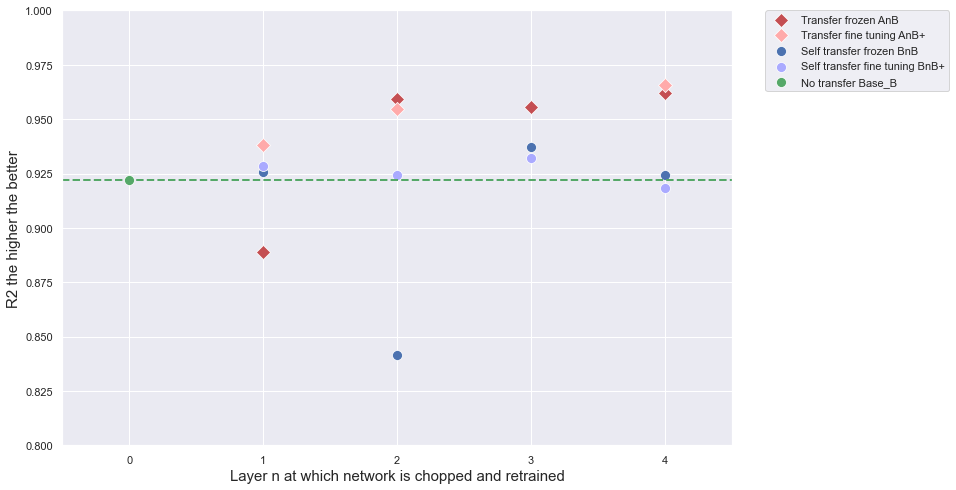

In [158]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
msize = 100
sns.set(rc={'figure.figsize':(12,8),'font.size': 16})
plt.xlim(-0.5, 4.5)
plt.ylim(0.8, 1)
ax = sns.scatterplot(x=[1,2,3,4], y="R2_mean", data=df_AnB_frozen_result, label='Transfer frozen AnB', marker='D', color = 'r', s=msize)
ax = sns.scatterplot(x=[1,2,3,4], y="R2_mean", data=df_AnB_fine_result, label='Transfer fine tuning AnB+', marker = 'D', color = '#ffaaaa', s=msize)
ax = sns.scatterplot(x=[1,2,3,4], y="R2_mean", data=df_BnB_frozen_result, label='Self transfer frozen BnB', marker ='o', color = 'b', s=msize)
ax = sns.scatterplot(x=[1,2,3,4], y="R2_mean", data=df_BnB_fine_result, label='Self transfer fine tuning BnB+', marker ='o', color = '#aaaaff', s=msize)
ax = sns.scatterplot(x=[0], y=df_base_B_result["R2_mean"].values, label='No transfer Base_B', marker ='o', color = 'g', s=msize)
ax.axhline(df_base_B_result["R2_mean"].values, ls='--', linewidth = 2, color = 'g')
plt.xlabel('Layer n at which network is chopped and retrained', fontsize=15)
plt.ylabel('R2 the higher the better', fontsize=15)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

In [170]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# titanic = sns.load_dataset("titanic")
# #print(titanic)
# sns.pointplot(x="deck", y="survived", hue="sex", data=titanic,
# palette={"male": "g", "female": "m"}, markers=["^", "o"], linestyles=["-", "--"], capsize=0.1)
# plt.show()